In [1]:
## Deepwalk only takes in INTEGERS as nodes


from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from random import choice
import urllib.request  # the lib that handles the url stuff
import time

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import zero_one_loss
from itertools import *


torch.cuda.empty_cache()

url = "https://raw.githubusercontent.com/gracexwho/drug-drug-interactions/master/ChCh-Miner_durgbank-chem-chem.tsv"
url_data = urllib.request.urlopen(url) 

G = nx.read_edgelist(url_data)

print(G.number_of_nodes())
print(G.number_of_edges())


# Create an experiment
experiment = Experiment(api_key="yeThLw8MLFuaMF3cVW1b9IsIt",
                        project_name="Node2Vec", workspace="gracexwho")

# Report any information you need by:

1514
48514


COMET INFO: old comet version (2.0.2) detected. current: 2.0.13 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/gracexwho/node2vec/6fade0af5fd74d07822ad7bd1214fbdf



In [2]:


################# CONTROL ##################

hyper_params = {"learning_rate": 0.05, "epochs": 5000, "num_walks": 500, "walk_length": 5, "window_size": 3}
experiment.log_parameters(hyper_params)

#hyper_params = {"learning_rate": 0.1, "epochs": 5000, "num_walks": 100, "walk_length": 5, "window_size": 3}
#experiment.log_parameters(hyper_params)


################# CONTROL ##################

In [3]:
import random
## Always "Restart Kernel and Clear Output if you're going to train again"


id_map = {}
edges = list(G.edges())
#print(edges[0])



def get_id(id_string):
    if id_string in id_map.keys():
        return id_map[id_string]
    else:
        ID = len(id_map)
        id_map[id_string] = ID
        return ID
    
edge_numbers = [(get_id(e[0]), get_id(e[1])) for e in edges]
#print(edge_numbers)


D = nx.Graph()
D.add_edges_from(edge_numbers)
print(D.number_of_edges())


### This generates the edgelist for DeepWalk
nx.write_edgelist(D, 'dw.edgelist')



48514


In [4]:
# Generate random walks

import random
## Always "Restart Kernel and Clear Output if you're going to train again"

pairs = []

for i in range(hyper_params['num_walks']):
    current = choice(list(G.nodes()))
    walk = [current]
    y = []
    
    for w in range(hyper_params['walk_length']):
        # walk to an adjacent node
        # error: some adjacent nodes are NOT IN the training set
        c = list(G.adj[current])
        current = choice(c)
        walk.append(current)
    
    # take permutations as closely related within the window size
    y = [permutations(walk[i : i+hyper_params['window_size']], 2) for i in range(len(walk)-hyper_params['window_size'])]
    z = []
    for l in y:
        z.extend(list(l))
    pairs.extend(z)

# remove duplicates
pairs = list(dict.fromkeys(pairs))


class Encoder(nn.Module):
  # should return VECTORS for each node
    def __init__(self):
        super(Encoder, self).__init__()
        
        #self.dropout = nn.Dropout(p=0.2)
        # one layer, return embeds(node_ids) which is a long tensor
        #learnrate might be too big if doesn't decrease
        self.embed = nn.Embedding(G.number_of_nodes(), 64)

    
    def forward(self, x):
        # take the node name as input and 
        x = self.embed(x)
        return x


def process_batch(batch):
    left_ids = torch.cuda.LongTensor([get_id(pair[0]) for pair in batch])
    right_ids = torch.cuda.LongTensor([get_id(pair[1]) for pair in batch])
    neg_ids = torch.cuda.LongTensor([np.random.randint(0, G.number_of_nodes()) for _ in batch])
    
    #print(left_ids)
    left_embeds = model(left_ids)
    right_embeds = model(right_ids)
    neg_embeds = model(neg_ids)
    
    pos_score = torch.mm(torch.t(left_embeds), right_embeds)
    neg_score = torch.mm(torch.t(left_embeds), neg_embeds)
    
    loss = get_loss(pos_score, neg_score)
    return loss
    
                          
def get_loss(pos, neg):
    m = nn.Sigmoid()
    loss = -torch.mean(torch.log(m(pos))) - torch.mean(torch.log(1 - m(neg)))
    return loss



def common_neighbours(T, u, v):
    Unodes = list(T.adj[u])
    Vnodes = list(T.adj[v])
    matches = [x for x in Unodes if x in Vnodes]
    return iter(matches)

def jaccard_index(T, u, v):
    common = len(list(common_neighbours(T, u, v)))
    union = T.degree[u] + T.degree[v] - common
    if union == 0:
        return 0
    else:
        return (common/union)

def adamic_adar(T, u, v):
    common = common_neighbours(T, u, v)
    total = 0
    for c in common:
        total = total + 1/np.log(T.degree[c])
    return total

def CN(T, edges):
    CN = {}
    for (u,v) in edges:
        CN[(u,v)] = len(list(common_neighbours(T,u,v)))
    return CN.values()


def JC(T, edges):
    JC = {}
    for (u,v) in edges:
        JC[(u,v)] = jaccard_index(T, u, v)
    return JC.values()


def AA(T, edges):
    AA = {}
    for (u,v) in edges:
        AA[(u,v)] = adamic_adar(T, u, v)
    return AA.values()

In [5]:
# Split graph into training and validation set
import random


url = "https://raw.githubusercontent.com/gracexwho/drug-drug-interactions/master/ChCh-Miner_durgbank-chem-chem.tsv"
url_data = urllib.request.urlopen(url) 
T = nx.read_edgelist(url_data)
V = nx.Graph()

num_val = 20000
num_neg = 20000


val_set = random.sample(list(T.edges()), num_val)
T.remove_edges_from(val_set)
V.add_edges_from(val_set)

T.remove_nodes_from(list(nx.isolates(T)))
# this removes nodes that don't have any neighbors from training graph

num_train = num_neg + T.number_of_edges()


print(T.number_of_edges())
print(T.number_of_nodes())

print("Number of validation edges", num_val)
print("Number of training edges", num_train)


28514
1449
Number of validation edges 20000
Number of training edges 48514


In [6]:
model = Encoder()
model.embed.weight.data = (model.embed.weight.data/np.sqrt(64))
model.to('cuda')

optimizer = optim.SGD(model.parameters(), lr=hyper_params['learning_rate'])

epochs = hyper_params['epochs']

#for n in list(list(G.nodes())):
#    get_id(n)

#pairs = [(get_id(pair[0]) , get_id(pair[1])) for pair in pairs]


alpha = 0.9
train_loss = 0
ep = hyper_params['epochs']

for e in range(ep):
    random.shuffle(pairs)
    train_loss = 0
    batch_size = 64
    batch = []
    index=0
    # the reason you can't use training_loss for optimizer is because train_loss isn't defined within the while loop
    # try doing train_loss.back() OUTSIDE of while loop?
    
    while index+batch_size < len(pairs):
        batch = pairs[index:min(index+batch_size, len(pairs))]
        index += batch_size
        
        #print(batch)
        loss = process_batch(batch)
        train_loss = alpha * train_loss + (1-alpha)*loss
        
    optimizer.zero_grad() 
    train_loss.backward()        #change back to loss if retain_graph error
    optimizer.step()
        #print("loss", loss)
        
    if e % 500 == 0:
        print("Training loss: ", train_loss)
        

      
torch.save(model.state_dict(), 'node2vec.pth')
    
print("done")

Training loss:  tensor(1.3902, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3906, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3907, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3904, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3899, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3898, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3899, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3905, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3901, device='cuda:0', grad_fn=<AddBackward0>)
Training loss:  tensor(1.3898, device='cuda:0', grad_fn=<AddBackward0>)
done


In [7]:
import collections
import subprocess


### deepwalk --format edgelist --input hamilton-lab/dw.edgelist --output dw.embeddings
# This is the code to run deepwalk and generate the embeddings


args = ["deepwalk "]
args.append("--format edgelist ")
args.append("--input hamilton-lab/dw.edgelist ")
args.append("--output dw.embeddings")
        
string =""
for x in args:
    string+=x
subprocess.call(string,shell=True)


############################################################################Now we read the embeddings into python

embeds = pd.read_csv('dw.embeddings', sep=" ", header=None)
embeds.head()
#torch_tensor = torch.tensor(targets_df['targets'].values)

e_parse = embeds.iloc[:, 0:]
e_parse.head()

e_dict = {}


#So basically deepwalk took the edgelist (integers)

for index, row in e_parse.iterrows():
    e_dict[int(row.values[0])] = row.values[1:]


e_dict = collections.OrderedDict(sorted(e_dict.items()))

e_array = np.array(list(e_dict.values()))
e_torch = torch.cuda.FloatTensor(e_array)
print(e_torch.shape)


torch.Size([1514, 64])


In [8]:
##################### TRAINING LOOP ######################
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import zero_one_loss


start_time = time.time()


class LogisticRegression(torch.nn.Module):
     
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(64, 1)
        #self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

    
link_model = LogisticRegression()
criterion = torch.nn.BCELoss(reduction='mean')         # this is already binary cross entropy!
optimizer_link = torch.optim.SGD(link_model.parameters(), lr = 0.05) 
weight = e_torch

train_edges = list(T.edges())
val_edges = list(V.edges())

y_label = [1]*len(train_edges)
neg = [0]*num_neg
y_label = y_label + neg
y_label = np.array(y_label)


negs = random.sample(list(nx.non_edges(T)), num_neg)
train_edges = train_edges + negs


left = [pair[0] for pair in train_edges]
right = [pair[1] for pair in train_edges]
left = [get_id(l) for l in left]
right = [get_id(r) for r in right]

left_ids = [weight[ids] for ids in left]
lf = torch.stack(left_ids)
right_ids = [weight[ids] for ids in right]
rg = torch.stack(right_ids)

#weight = torch.FloatTensor(np.random.rand(weight.shape[0], weight.shape[1]))

dot_prod = torch.bmm(lf.view(num_train, 1, 64), rg.view(num_train, 64, 1)) 
dot_prod = torch.squeeze(dot_prod)
dot_prod = dot_prod.cpu()
dotproduct = dot_prod.numpy()

score = roc_auc_score(y_label, dotproduct)
print("The auc score for dot product is: ", score)




link_model.to('cuda')


element_mul = (lf * rg)
#element_mul = (lf + rg)
element_mul = element_mul.cuda()
y_label_model = torch.cuda.FloatTensor(y_label)

print(element_mul[0])

link_model.train()


# Keep it at 5000, more is overfitting

ra = 10000
for e in range(ra):
    optimizer_link.zero_grad() 
    y_pred = link_model(element_mul)
    y_pred = torch.squeeze(y_pred)
    loss = criterion(y_pred, y_label_model)
    loss.backward() 
    optimizer_link.step() 
    auc = roc_auc_score(y_label, y_pred.cpu().detach().numpy())
    if e % 2000 == 0:
        print("AUC for DW: ", auc)
        print(loss)
    
print("Here's the graph index value:")
test = list(AA(T, train_edges))
print(roc_auc_score(y_label, test))
    
torch.save(link_model.state_dict(), 'linkpred.pth')
        
print("--- %s minutes ---" % ((time.time() - start_time)//60))
    

# If you get CUDA error, just keep running again and it'll work

The auc score for dot product is:  0.7827389299992986
tensor([-5.9784e-02,  3.7626e-02,  1.0528e-02, -4.5668e-04, -1.0723e-01,
         1.0495e-02,  2.5439e-01,  7.2921e-03,  1.8593e-01,  8.2330e-02,
         2.6766e-04,  1.1402e-02,  4.1260e-02, -2.2414e-03,  2.1050e-03,
         1.0506e-01,  7.9224e-03,  2.3251e-02,  6.8249e-02, -2.5231e-02,
         6.1739e-02,  3.2313e-03, -9.9942e-03, -4.3819e-04,  1.4042e-02,
         1.7460e-02, -3.3543e-04, -5.8468e-02,  3.3231e-02, -3.5055e-03,
        -2.3886e-02, -4.8635e-03,  2.5647e-01,  3.8310e-01,  3.3073e-03,
        -1.3138e-02,  1.0396e-01,  7.8440e-02,  2.2643e-02,  1.4292e-02,
        -3.4399e-02,  1.5821e-02,  3.0342e-01,  2.3252e-02, -1.6596e-02,
         2.2186e-02, -2.1203e-03, -2.1770e-03, -1.5014e-01, -1.5266e-01,
         1.7729e-01,  4.1302e-02,  9.8873e-03, -2.4555e-02,  2.6494e-02,
        -6.3229e-02,  4.0788e-04, -4.8796e-02, -3.7495e-02,  5.4090e-04,
         2.3566e-01,  1.1534e-02,  4.3001e-02, -3.0180e-03], device='c

In [9]:
link_model2 = LogisticRegression()
criterion = torch.nn.BCELoss(reduction='mean')         # this is already binary cross entropy!
optimizer_link2 = torch.optim.SGD(link_model2.parameters(), lr = 0.05) 
nv_weight = model.embed.weight.data * 10


left = [pair[0] for pair in train_edges]
right = [pair[1] for pair in train_edges]
left = [get_id(l) for l in left]
right = [get_id(r) for r in right]
left_ids = [nv_weight[ids] for ids in left]
lf = torch.stack(left_ids)
right_ids = [nv_weight[ids] for ids in right]
rg = torch.stack(right_ids)


#weight = torch.FloatTensor(np.random.rand(weight.shape[0], weight.shape[1]))

dot_prod = torch.bmm(lf.view(num_train, 1, 64), rg.view(num_train, 64, 1)) 
dot_prod = torch.squeeze(dot_prod)
dot_prod = dot_prod.cpu()
dotproduct = dot_prod.numpy()

score = roc_auc_score(y_label, dotproduct)
print("The auc score for dot product is: ", score)


link_model2.to('cuda')


element_mul = (lf * rg)
#element_mul = (lf + rg)
element_mul = element_mul.cuda()
y_label_model = torch.cuda.FloatTensor(y_label)

print(element_mul[0])

link_model.train()


# Keep it at 5000, more is overfitting

ra = 10000
for e in range(ra):
    optimizer_link2.zero_grad() 
    y_pred = link_model2(element_mul)
    y_pred = torch.squeeze(y_pred)
    loss = criterion(y_pred, y_label_model)
    loss.backward() 
    optimizer_link2.step() 
    auc = roc_auc_score(y_label, y_pred.cpu().detach().numpy())
    if e % 2000 == 0:
        print("N2V AUC:", auc)
        print(loss)
    
print("Here's the graph index value:")
test = list(AA(T, train_edges))
print(roc_auc_score(y_label, test))
    
torch.save(link_model2.state_dict(), 'linkpred2.pth')

The auc score for dot product is:  0.49722055656870306
tensor([ 2.0199, -0.9331, -0.5022, -0.6935, -1.2088, -0.6734, -1.9415, -0.3627,
         0.1830,  0.5887, -4.0954,  0.3167, -0.1253, -0.1223,  0.3749,  0.4686,
         0.4442, -1.3036,  2.6854, -1.1814, -0.9703, -0.8967,  1.8376, -3.1070,
         0.0129,  0.0277, -0.0305,  1.0123,  0.0838, -2.3389,  0.5868, -1.4772,
         1.1369,  0.8537,  0.8397, -0.6591,  0.5706,  3.0860,  0.0157,  0.3537,
        -0.0853,  1.8214,  0.3529,  0.9826, -0.0511, -0.0359,  0.5521, -0.5440,
         0.0748,  0.0653, -0.2372,  0.7499, -1.2783, -0.2879,  3.4844, -0.1417,
        -0.5484,  2.2564,  0.1753, -0.6240,  0.2594,  1.1143,  0.5642, -0.5556],
       device='cuda:0')
N2V AUC: 0.5039208695728414
tensor(0.7881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
N2V AUC: 0.5234485200252508
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
N2V AUC: 0.5234485200252508
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntr

In [10]:
########### VALIDATION LOOP ##############
y_hat = []
y_true = [1]*len(val_edges)
neg = [0]*num_val
y_true = y_true + neg
y_true = np.array(y_true)

y_hat2 = []
y_true2 = [1]*len(val_edges)
neg2 = [0]*num_val
y_true2 = y_true2 + neg
y_true2 = np.array(y_true)

negs = random.sample(list(nx.non_edges(V)), num_val)
val_edges = val_edges + negs


link_model.eval()
link_model2.eval()

for (x,y) in val_edges:
    u = weight[get_id(x)]
    v = weight[get_id(y)]
    a = nv_weight[get_id(x)]
    b = nv_weight[get_id(y)]
    em = u * v
    em = em.cuda()
    em2 = a * b
    em2 = em.cuda()
    pred = link_model(em)
    pred2 = link_model2(em2)
    y_hat.append(pred.item())
    y_hat2.append(pred2.item())

print("done")

done


In [11]:
accuracy = roc_auc_score(y_true, y_hat)
accuracy2 = roc_auc_score(y_true2, y_hat2)

jaccard = list(JC(V, val_edges))
jaccard2 = roc_auc_score(y_true, jaccard)

adamic = list(AA(V, val_edges))
adamic2 = roc_auc_score(y_true, adamic)

common = list(CN(V, val_edges))
common2 = roc_auc_score(y_true, common)


print("The auc score for DW elementwise mul: ", accuracy)
print("The AUC for node2vec EM is: ", accuracy2)
print("The auc score for JC index: ", jaccard2)
print("The auc score for AA index: ", adamic2)
print("The auc score for CN index: ", common2)



The auc score for DW elementwise mul:  0.83849796125
The AUC for node2vec EM is:  0.5082075225
The auc score for JC index:  0.8255201474999999
The auc score for AA index:  0.8543261299999998
The auc score for CN index:  0.8518716149999999


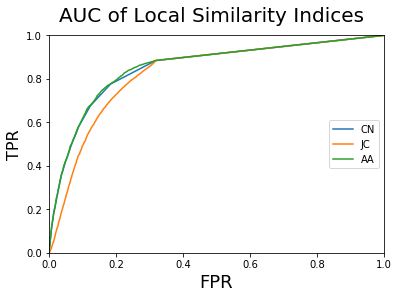

In [12]:
[fpr, tpr, thresh] = roc_curve(y_true, common)

ratioMax = tpr - fpr

fig1 = plt.figure()
common_line, = plt.plot(fpr, tpr, label='CN')

fig1.suptitle('AUC of Local Similarity Indices', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.axis([0, 1.0, 0, 1.0])                      # set [xmin, xmax, ymin, ymax]


[fpr2, tpr2, thresh2] = roc_curve(y_true, jaccard)
ratioMax = tpr2 - fpr2
jaccard_line, = plt.plot(fpr2, tpr2, label='JC')


[fpr3, tpr3, thresh3] = roc_curve(y_true, adamic)
ratioMax = tpr3 - fpr3
adamic_line, = plt.plot(fpr3, tpr3, label='AA')


plt.legend(handles=[common_line, jaccard_line, adamic_line], loc='center right')


fig1.savefig('Node2Vec_Indices.jpg')